# Transfert learning avec TensorFlow

## Introduction

Dans ce notebook, nous allons explorer le concept de transfert learning en utilisant TensorFlow.

### Objectif

L'objectif de ce notebook est de :

1. Comprendre le concept de transfert learning.
2. Implémenter le transfert learning en utilisant un modèle pré-entraîné dans TensorFlow.
3. Affiner le modèle pré-entraîné sur un ensemble de données personnalisé.

### 1. Importation des bibliothèques et chargement des données

Commençons par importer les bibliothèques nécessaires et charger notre ensemble de données. Pour cet exemple, nous utiliserons l'ensemble de données suivant:
https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery/data

L'archive contient un fichier .json décrivant les données.
A partir du fichier .json, construisez un dataset Tensorflow. Pour cela :
1. Ouvrez le fichier .json, explorez les données.
2. Les données correspondant aux images contiennent successivement 3 canaux. Réorganisez les dimensions des images pour pouvoir les utiliser dans un dataset.
3. Récupérez les labels. Encodez les en one-hot.
4. Construisez le dataset, et préparez le pour l'entrainement.


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rhammell/ships-in-satellite-imagery")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ships-in-satellite-imagery' dataset.
Path to dataset files: /kaggle/input/ships-in-satellite-imagery


In [2]:
import os
os.listdir(path)

['shipsnet', 'shipsnet.json', 'scenes']

In [3]:
import pandas as pd

df = pd.read_json(path+"/shipsnet.json")

In [4]:
import numpy as np
X = []
for data in df['data']:
  X.append(np.array(data).reshape(80,80,3))

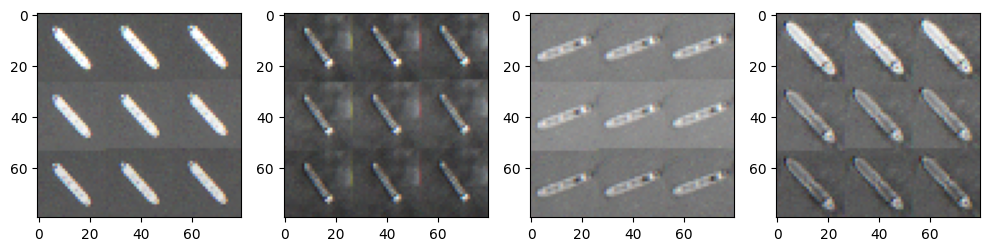

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i])
plt.tight_layout()
plt.show()


In [6]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y = encoder.fit_transform(df[['labels']])

In [7]:
dataset = pd.DataFrame({'X':X, 'y':y})

In [8]:
X_array = np.array(dataset['X'].tolist(), dtype='float32')  # shape -> (n_samples, H, W, C)

In [9]:
y_array = y.toarray().astype('float32')


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.25)

### 2. Chargement du modèle pré-entrainé

Chargez le modèle Tensorflow ResNet50 entrainé sur imagenet en ne gardant que la partie avec couches convolutionnelles (option 'include_top'). Gelez les poids de toutes les couches du réseau (cette partie du modèle final ne sera pas entrainée).

In [11]:
import tensorflow as tf
resNet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')

for layer in resNet.layers[-2:]:
  layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
resNet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

### 3. Construction et compilation du modèle

Intégrez le modèle de ResNet50 dans un modèle final en rajoutant une couche de GlobalAveragePooling2D et deux couches Dense, puis compilez le modèle.

In [13]:
new_model = tf.keras.Sequential()
new_model.add(resNet)
new_model.add(tf.keras.layers.GlobalAveragePooling2D())
new_model.add(tf.keras.layers.Dense(256))
new_model.add(tf.keras.layers.Dense(128))
new_model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [14]:
adam = tf.keras.optimizers.Adam()
new_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

### 4. Entrainement et visualisation des résultats

Entrainez le modèle final pour 10 epochs, puis visualisez les courbes d'accuracy et de loss.

In [38]:
results_1 = new_model.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9960 - loss: 0.0116
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9974 - loss: 0.0060
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9979 - loss: 0.0057
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9984 - loss: 0.0027
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9972 - loss: 0.0105
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9993 - loss: 0.0028
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.9990 - loss: 0.0029
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.9976 - loss: 0.0089
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9994 - loss: 0.0026
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9986 - loss: 0.0028


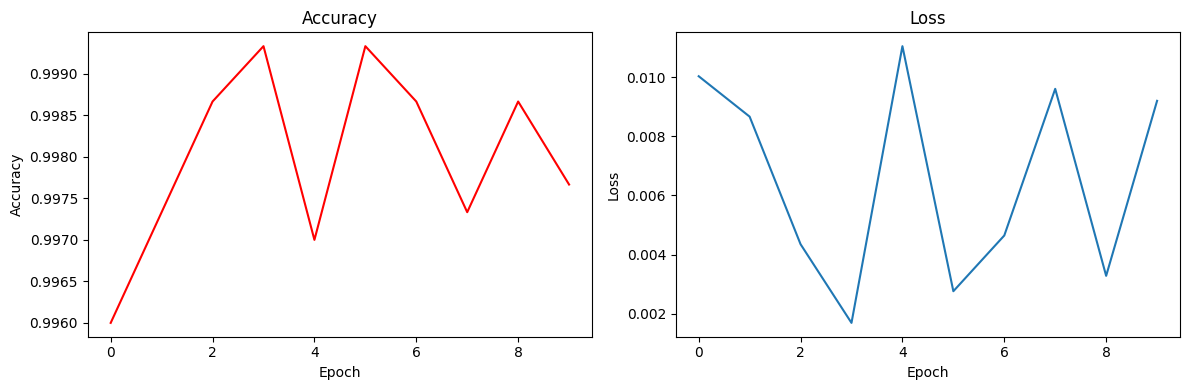

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy
axs[0].plot(results_1.history['accuracy'], c='r')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')

# Loss
axs[1].plot(results_1.history['loss'])
axs[1].set_title('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

### 5. Fine-tuning des paramètres

Décongelez les poids des deux dernières couches de convolution de ResNet50, puis recompilez le modèle final et poursuivez l'entrainement pour 5 epochs de plus

In [40]:
for layer in resNet.layers[-2:]:
  layer.trainable = True

In [41]:
new_model = tf.keras.Sequential()
new_model.add(resNet)
new_model.add(tf.keras.layers.GlobalAveragePooling2D())
new_model.add(tf.keras.layers.Dense(256))
new_model.add(tf.keras.layers.Dense(128))
new_model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [42]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
new_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [43]:
results_2 = new_model.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 80s 280ms/step - accuracy: 0.8492 - loss: 0.2750
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9989 - loss: 0.0041
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9961 - loss: 0.0181
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9993 - loss: 0.0019
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9999 - loss: 0.0018
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9993 - loss: 0.0030
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9978 - loss: 0.0042
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.9995 - loss: 0.0021
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9976 - loss: 0.0078
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9997 - loss: 0.0016


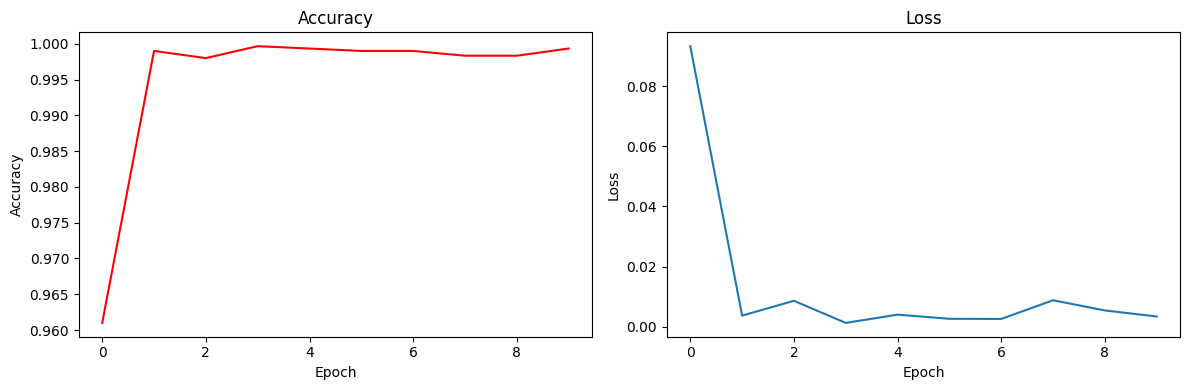

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy
axs[0].plot(results_2.history['accuracy'], c='r')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')

# Loss
axs[1].plot(results_2.history['loss'])
axs[1].set_title('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

### 6. Evaluez le modèle final sur l'ensemble de test

In [46]:
results_3 = new_model.fit(X_test, y_test, epochs=10, verbose=1)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 786ms/step - accuracy: 0.9929 - loss: 0.0294
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9962 - loss: 0.0175
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9989 - loss: 0.0045
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 5.6665e-04
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 1.0000 - loss: 6.8408e-04
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - loss: 1.7155e-04
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9999 - loss: 0.0026    
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9938 - loss: 0.0167
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9997 - loss: 0.0141
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9967 - loss: 0.0111


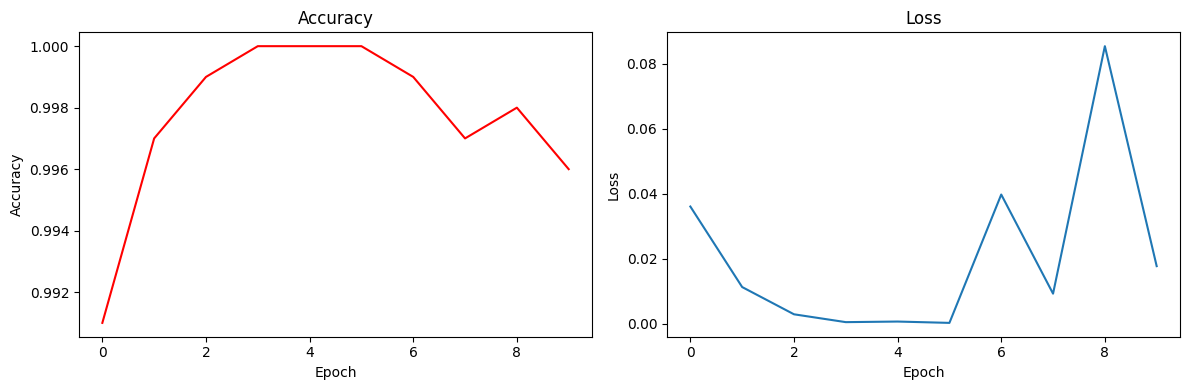

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy
axs[0].plot(results_3.history['accuracy'], c='r')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')

# Loss
axs[1].plot(results_3.history['loss'])
axs[1].set_title('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

Sur-apprentissage à partir de 4 epoch, il faut ré entrainer le modèle avec 4epoch pour avoir le modèle le plus performant

In [48]:
results_4 = new_model.fit(X_test, y_test, epochs=4, verbose=1)

Epoch 1/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9992 - loss: 0.0083
Epoch 2/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9961 - loss: 0.0050
Epoch 3/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9999 - loss: 6.3565e-04
Epoch 4/4
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9987 - loss: 0.0018


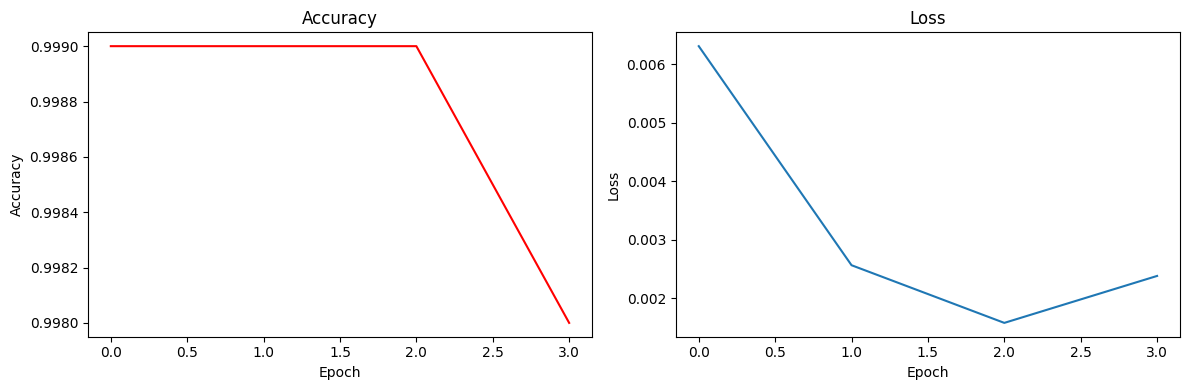

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy
axs[0].plot(results_4.history['accuracy'], c='r')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')

# Loss
axs[1].plot(results_4.history['loss'])
axs[1].set_title('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()